In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
from skimage import io
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image
import os
import soundfile as sf
import librosa
import cv2

/home/issa-sangare/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def details(path):
    img = Image.open(path)
    size = img.size
    format = img.format
    mode = img.mode
    resolution = img.info.get('dpi')[0]
    definition = size
    size = ((size[0]/resolution), (size[1]/resolution))
    # Calcul du poids de l'image
    poids = os.path.getsize(path) / (1000.0) # Converti en mégaoctets
    return size, format, mode, resolution, definition, poids

# Exemple d'utilisation
path_to_image = "eren_rgb.jpeg"
result = details(path_to_image)
print("Size (pouces):", result[0])
print("Format:", result[1])
print("Mode:", result[2])
print("Resolution (ppp):", result[3])
print("Definition (pixels):", result[4])
print("Poids (taille en mémoire):", result[5], "Ko")

Size (pouces): (4.2, 2.36)
Format: JPEG
Mode: RGB
Resolution (ppp): 300
Definition (pixels): (1260, 708)
Poids (taille en mémoire): 111.596 Ko


In [3]:
def create_color_palette(image, num_colors):
    # Convertir l'image en un tableau 2D de pixels
    pixels = np.reshape(image, (-1, 3))  # (nombre de pixels, 3 canaux de couleur)

    # Appliquer l'algorithme de k-means clustering
    kmeans = KMeans(n_clusters=num_colors)
    kmeans.fit(pixels)

    # Obtenir les centres des clusters (couleurs dominantes)
    color_palette = kmeans.cluster_centers_.astype(int)

    # Associer chaque pixel à l'indice de couleur dans la palette
    labels = kmeans.predict(pixels)

    # Reformater les indices des couleurs dans la palette selon la forme de l'image originale
    palette_indices = np.reshape(labels, image.shape[:2])

    return color_palette, palette_indices
  
# Charger l'image d'exemple
image = io.imread('eren_rgb.jpeg')

def reconstruct_image(color_palette, palette_indices):
    # Create an empty array to store the reconstructed image
    reconstructed_image = np.zeros((palette_indices.shape[0], palette_indices.shape[1], 3), dtype=np.uint8)

    # Map each palette index to its corresponding color in the color palette
    for i in range(color_palette.shape[0]):
        # Find pixels with the current palette index and assign the corresponding color
        reconstructed_image[palette_indices == i] = color_palette[i]

    return reconstructed_image

/home/issa-sangare/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


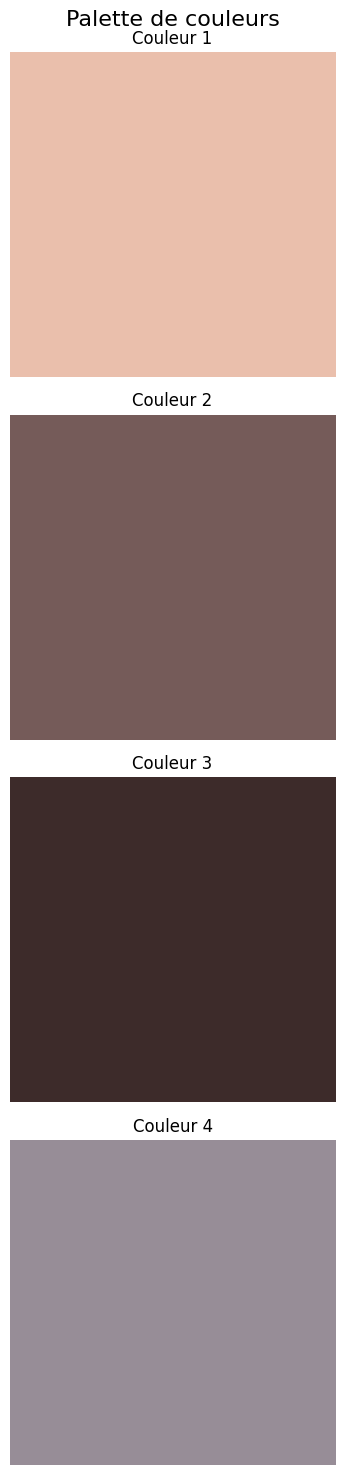

In [4]:
# Créer une palette de 5 couleurs à partir de l'image
num_colors = 4
color_palette, palette_indices = create_color_palette(image, num_colors)

# Afficher la palette de couleurs
num_rows = 4
num_cols = num_colors // num_rows
plt.figure(figsize=(30, 15))
for i, color in enumerate(color_palette):
    plt.subplot(num_rows, num_cols, i + 1)
    color_patch = np.zeros((100, 100, 3), dtype=np.uint8)
    color_patch[:, :] = color
    plt.imshow(color_patch)
    plt.title(f'Couleur {i+1}')
    plt.axis('off')
plt.suptitle('Palette de couleurs', fontsize=16)
plt.tight_layout()
plt.show()

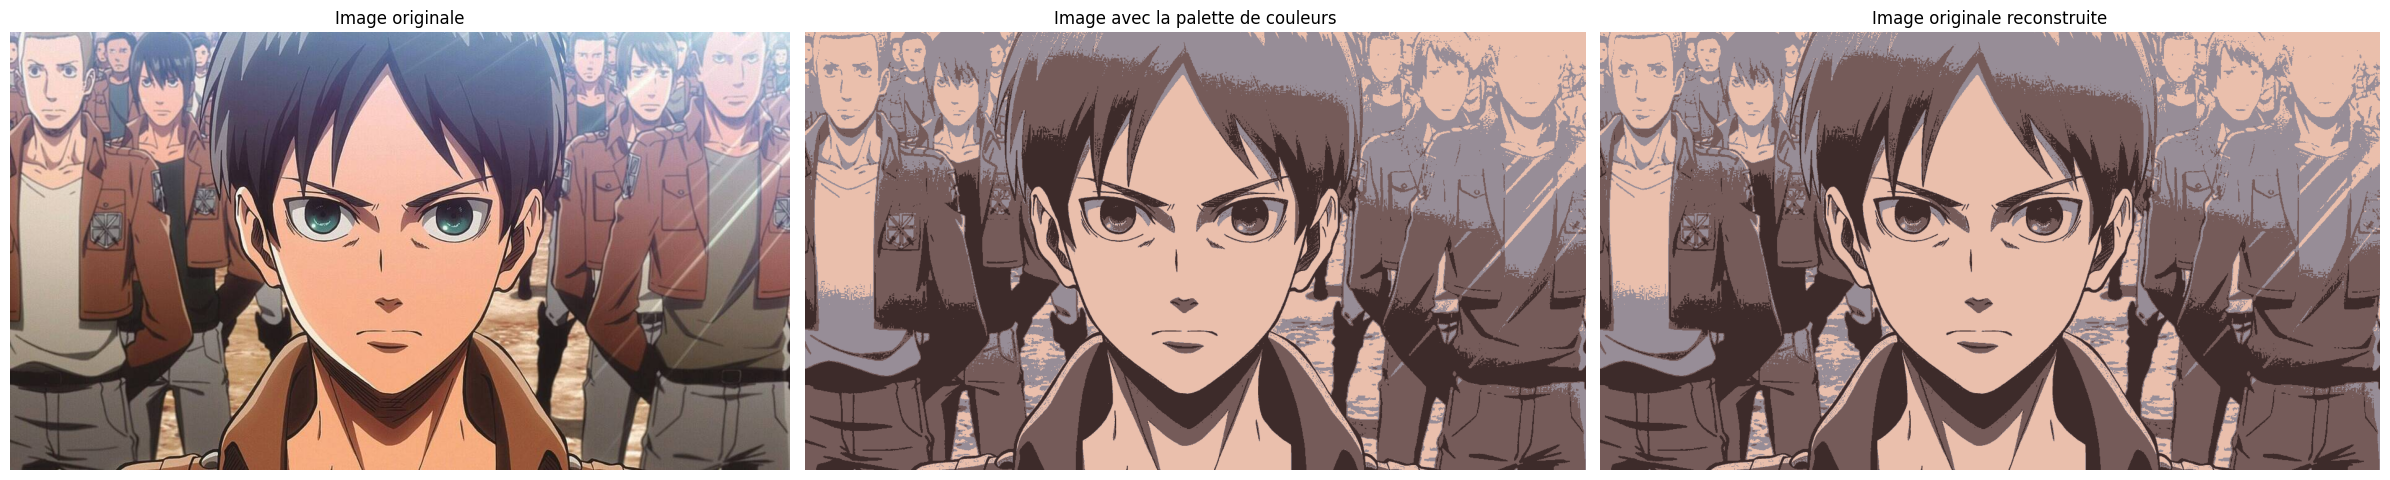

In [5]:
# Exemple d'utilisation :
image_path = "eren_rgb.jpeg"
image = io.imread(image_path)

reconstructed_image = reconstruct_image(color_palette, palette_indices)

fig, axs = plt.subplots(1, 3, figsize=(24, 10))

axs[0].imshow(image)
axs[0].set_title('Image originale')
axs[0].axis('off')

axs[1].imshow(color_palette[palette_indices])
axs[1].set_title('Image avec la palette de couleurs')
axs[1].axis('off')

axs[2].imshow(reconstructed_image)
axs[2].set_title('Image originale reconstruite')
axs[2].axis('off')

fig.tight_layout()

plt.show()

In [6]:
def map_image_to_palette(image, color_palette):
    # Convertir l'image en un tableau 2D de pixels
    pixels = np.reshape(image, (-1, 3))  # (nombre de pixels, 3 canaux de couleur)

    # Initialiser un tableau pour stocker les indices de la palette de couleur pour chaque pixel
    palette_indices = np.zeros(len(pixels), dtype=int)

    # Pour chaque pixel, trouver l'indice de la couleur la plus proche dans la palette
    for i, pixel in enumerate(pixels):
        distances = np.linalg.norm(color_palette - pixel, axis=1)  # Calculer les distances euclidiennes
        closest_color_index = np.argmin(distances)  # Trouver l'indice de la couleur la plus proche
        palette_indices[i] = closest_color_index

    # Reformater les indices des couleurs dans la palette selon la forme de l'image originale
    palette_indices = np.reshape(palette_indices, image.shape[:2])

    return palette_indices.flatten()
  
# Mapper l'image à la palette de couleurs
palette_indices = map_image_to_palette(image, color_palette)

# Afficher la palette d'indices associée à l'image
print("Palette d'indices de couleurs:")
print(palette_indices[0:100])
print(len(palette_indices))

Palette d'indices de couleurs:
[3 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 3 3 0 0 0 0 0 0 0 0 3 0 0 0 0 0 3 3 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0]
892080


In [8]:
def compress(data, alphabet):
    dictionary = {}
    result = []
    current_code = len(alphabet)

    # Initialiser le dictionnaire avec les caractères de l'alphabet spécifié
    for i, char in enumerate(alphabet):
        dictionary[char] = i

    prefix = data[0]
    print(prefix)
    for char in data[1:]:
        new_entry = prefix + char
        if new_entry in dictionary:
            prefix = new_entry
        else:
            result.append(dictionary[prefix])
            print(result)
            dictionary[new_entry] = current_code
            current_code += 1
            prefix = char

    result.append(dictionary[prefix])
    return result

def decompress(compressed_data, alphabet):
    dictionary = {}
    result = []
    current_code = len(alphabet)

    # Initialiser le dictionnaire avec les caractères de l'alphabet spécifié
    for i, char in enumerate(alphabet):
        dictionary[i] = char

    old_entry = dictionary[compressed_data.pop(0)]
    result.append(old_entry)
    for new_entry in compressed_data:
        if new_entry in dictionary:
            entry = dictionary[new_entry]
        elif new_entry == current_code:
            entry = old_entry + old_entry[0]
        else:
            raise ValueError("Mauvaise séquence compressée")

        result.append(entry)

        dictionary[current_code] = old_entry + entry[0]
        current_code += 1
        old_entry = entry

    return ''.join(result)
  
# Générer l'alphabet de 0 à 255
alphabet = [str(i) for i in range(256)]
# Convertir la palette d'indices en une chaîne de caractères
palette_indices_str = ''.join(map(str, palette_indices.flatten()))
# Appliquer la compression à la palette d'indices
compressed_palette_indices = compress(palette_indices_str, alphabet)
print(len(compressed_palette_indices))
print(palette_indices_str[0:100])
print(compressed_palette_indices[0:100])

In [ ]:
def MSE(image_d_origine, image_traitee):
    # Convertir les images en tableaux NumPy
    origine = np.array(image_d_origine)
    traitee = np.array(image_traitee)
    
    # Redimensionner l'image traitée pour avoir la même forme que l'image d'origine
    traitee = traitee.reshape(origine.shape)
    # Calcul de la somme de la différence au carré
    somme_differences_carrees = np.sum((origine - traitee) ** 2)

    # Calcul de (1 / (L * C)) * somme
    resultat = (1 / np.prod(origine.shape)) * somme_differences_carrees

    return resultat


# Exemple d'utilisation avec deux matrices (image_nv_gris et image_amelioree)
erreur1 = MSE(Image.open('eren_rgb.jpeg'), reconstructed_image)
erreur2 = MSE(Image.open('eren_rgb.jpeg'), color_palette[palette_indices])
print(f"L'erreur quadratique moyenne 1 (MSE) est: {erreur1}")
print(f"L'erreur quadratique moyenne 2 (MSE) est: {erreur2}")

L'erreur quadratique moyenne 1 (MSE) est: 93.3079387498879
L'erreur quadratique moyenne 2 (MSE) est: 478.3030251397483


In [ ]:
def PSNR(image_d_origine, image_traitee):
    origine = np.array(image_d_origine)
    traitee = np.array(image_traitee)
    max_val = origine.max()
    traitee = traitee.reshape(origine.shape)

    return 10 * np.log10((max_val ** 2) / MSE(image_d_origine, image_traitee))

crete1 = PSNR(Image.open('eren_rgb.jpeg'), reconstructed_image)
crete2 = PSNR(Image.open('eren_rgb.jpeg'), color_palette[palette_indices])
print(f"Le rapport signal sur bruit de crête 1 (PSNR) est: {crete1}")
print(f"Le rapport signal sur bruit de crête 2 (PSNR) est: {crete2}")

Le rapport signal sur bruit de crête 1 (PSNR) est: 28.431617652607905
Le rapport signal sur bruit de crête 2 (PSNR) est: 21.333772331898725


In [ ]:
def preprocess_audio(file_path):
    """
    Preprocesses the audio signal for normalization.

    Args:
    - file_path: path to the audio file

    Returns:
    - preprocessed_signal: numpy array representing the preprocessed audio signal
    """
    # Charger le fichier audio
    audio_signal, sample_rate = sf.read(file_path)

    # Convertir le signal audio en valeurs flottantes
    audio_signal = audio_signal.astype(np.float32)

    # Normaliser le signal audio (mettre à l'échelle entre -1 et 1)
    max_amplitude = np.max(np.abs(audio_signal))
    if max_amplitude > 0:
        preprocessed_signal = audio_signal / max_amplitude
    else:
        preprocessed_signal = audio_signal

    return preprocessed_signal, sample_rate

# Exemple d'utilisation
file_path = "audio2.wav"
preprocessed_signal, sample_rate = preprocess_audio(file_path)
print("Signal audio prétraité normalisé:", preprocessed_signal)
print("Taux d'échantillonnage:", sample_rate)

Signal audio prétraité normalisé: [[ 0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  9.0317917e-05]
 [-4.5158959e-05  1.8063583e-04]
 ...
 [ 0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00]]
Taux d'échantillonnage: 44100


In [ ]:
def inverse_preprocess(preprocessed_signal, sample_rate, output_file):
    """
    Reverts the preprocessing of the audio signal.

    Args:
    - preprocessed_signal: numpy array representing the preprocessed audio signal
    - sample_rate: sample rate of the audio signal
    - output_file: path to save the reverted audio file

    Returns:
    - None
    """
    # Revert normalization
    audio_signal = preprocessed_signal * np.iinfo(np.int16).max

    # Save the audio file
    sf.write(output_file, audio_signal.astype(np.int16), sample_rate)

# Exemple d'utilisation
sample_rate = 44100  # Exemple de taux d'échantillonnage
output_file = "audio1.wav"  # Spécifiez le chemin de sortie

inverse_preprocess(preprocessed_signal, sample_rate, output_file)

In [ ]:


import numpy as np
import soundfile as sf

def preprocess_audio(file_path):
    """
    Preprocesses the audio signal for normalization.

    Args:
    - file_path: path to the audio file

    Returns:
    - preprocessed_signal: numpy array representing the preprocessed audio signal
    """
    # Charger le fichier audio
    audio_signal, sample_rate = sf.read(file_path)

    # Convertir le signal audio en valeurs flottantes
    audio_signal = audio_signal.astype(np.float32)

    # Normaliser le signal audio (mettre à l'échelle entre -1 et 1)
    max_amplitude = np.max(np.abs(audio_signal))
    if max_amplitude > 0:
        preprocessed_signal = audio_signal / max_amplitude
    else:
        preprocessed_signal = audio_signal

    return preprocessed_signal, sample_rate

# Exemple d'utilisation
file_path = "audio2.wav"
preprocessed_signal, sample_rate = preprocess_audio(file_path)
print("Signal audio prétraité normalisé:", preprocessed_signal)
print("Taux d'échantillonnage:", sample_rate)

Signal audio prétraité normalisé: [[ 0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  9.0317917e-05]
 [-4.5158959e-05  1.8063583e-04]
 ...
 [ 0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00]]
Taux d'échantillonnage: 44100


In [ ]:


import numpy as np
import soundfile as sf

def inverse_preprocess(preprocessed_signal, sample_rate, output_file):
    """
    Reverts the preprocessing of the audio signal.

    Args:
    - preprocessed_signal: numpy array representing the preprocessed audio signal
    - sample_rate: sample rate of the audio signal
    - output_file: path to save the reverted audio file

    Returns:
    - None
    """
    # Revert normalization
    audio_signal = preprocessed_signal * np.iinfo(np.int16).max

    # Save the audio file
    sf.write(output_file, audio_signal.astype(np.int16), sample_rate)

# Exemple d'utilisation
sample_rate = 44100  # Exemple de taux d'échantillonnage
output_file = "audio1.wav"  # Spécifiez le chemin de sortie

inverse_preprocess(preprocessed_signal, sample_rate, output_file)

In [ ]:
# Charger les fichiers audio
audio_file1 = 'audio1.wav'
audio_file2 = 'audio2.wav'

# Charger les signaux audio
signal1, sr1 = librosa.load(audio_file1)
signal2, sr2 = librosa.load(audio_file2)

# Assurer que les signaux ont la même longueur
min_length = min(len(signal1), len(signal2))
signal1 = signal1[:min_length]
signal2 = signal2[:min_length]

# Calculer la corrélation de Pearson entre les signaux
pearson_corr = np.corrcoef(signal1, signal2)[0, 1]

print("Corrélation de Pearson entre les deux signaux :", pearson_corr)

Corrélation de Pearson entre les deux signaux : 0.9999999993530051


/home/issa-sangare/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


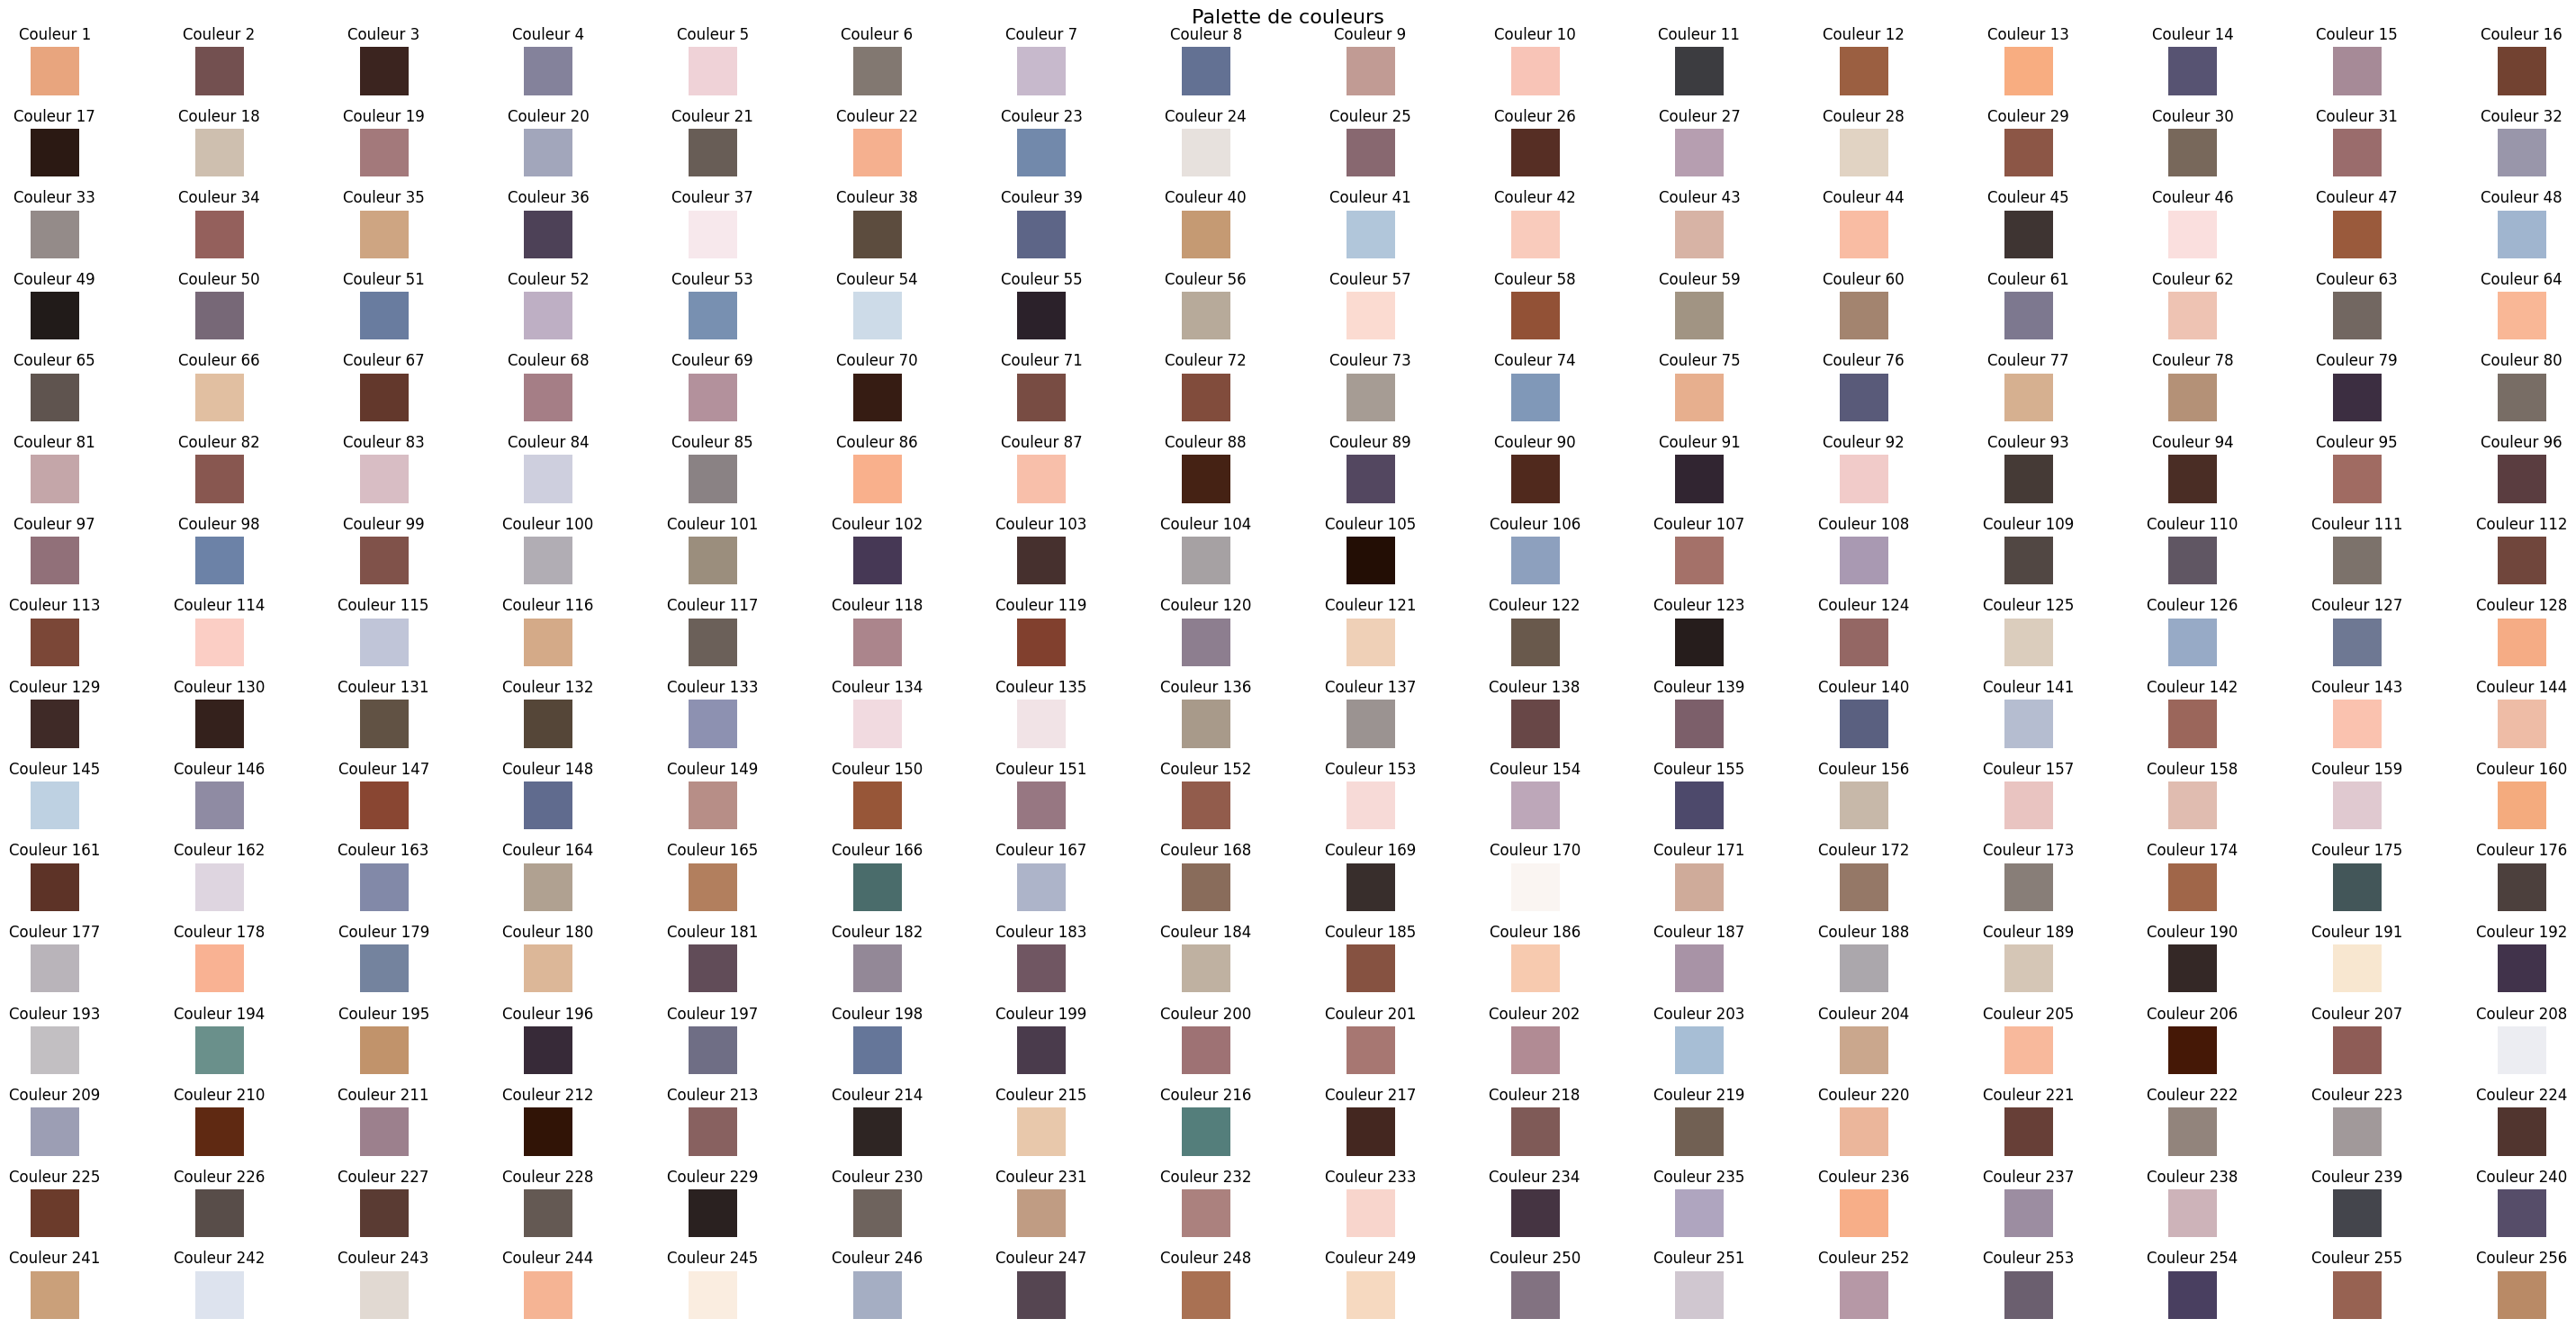

In [ ]:


# Créer une palette de 5 couleurs à partir de l'image
num_colors = 256
color_palette, palette_indices = create_color_palette(image, num_colors)

# Afficher la palette de couleurs
num_rows = 16
num_cols = num_colors // num_rows
plt.figure(figsize=(30, 15))
for i, color in enumerate(color_palette):
    plt.subplot(num_rows, num_cols, i + 1)
    color_patch = np.zeros((100, 100, 3), dtype=np.uint8)
    color_patch[:, :] = color
    plt.imshow(color_patch)
    plt.title(f'Couleur {i+1}')
    plt.axis('off')
plt.suptitle('Palette de couleurs', fontsize=16)
plt.tight_layout()
plt.show()

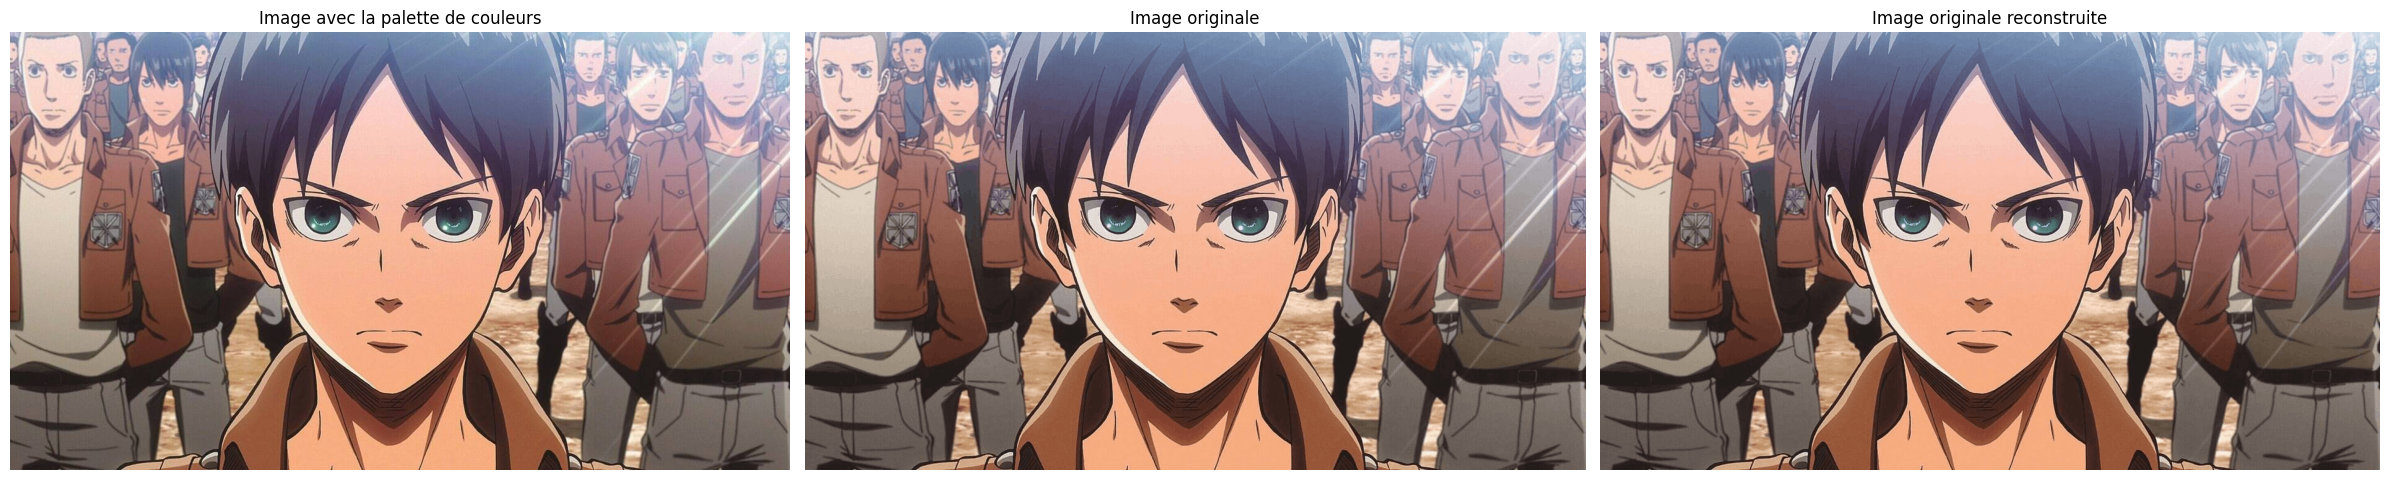

In [ ]:


# Exemple d'utilisation :
image_path = "eren_rgb.jpeg"
image = io.imread(image_path)

reconstructed_image = reconstruct_image(color_palette, palette_indices)

fig, axs = plt.subplots(1, 3, figsize=(24, 10))

axs[0].imshow(image)
axs[0].set_title('Image avec la palette de couleurs')
axs[0].axis('off')

axs[1].imshow(color_palette[palette_indices])
axs[1].set_title('Image originale')
axs[1].axis('off')

axs[2].imshow(reconstructed_image)
axs[2].set_title('Image originale reconstruite')
axs[2].axis('off')

fig.tight_layout()

plt.show()